# Shared Task: Critical thinking generation
## Loadind Data


In [1]:
import tqdm
# Reading the data
import json
import pandas as pd

from my_models.utils import get_st_data


for key, line in tqdm.tqdm(get_st_data("sample").items()):
    print(key)

    print(line['intervention'])
    input_text = line['intervention']
    break


  0%|          | 0/5 [00:00<?, ?it/s]

CLINTON_1_1
CLINTON: "The central question in this election is really what kind of country we want to be and what kind of future we 'll build together
Today is my granddaughter 's second birthday
I think about this a lot
we have to build an economy that works for everyone , not just those at the top
we need new jobs , good jobs , with rising incomes
I want us to invest in you
I want us to invest in your future
jobs in infrastructure , in advanced manufacturing , innovation and technology , clean , renewable energy , and small business
most of the new jobs will come from small business
We also have to make the economy fairer
That starts with raising the national minimum wage and also guarantee , finally , equal pay for women 's work
I also want to see more companies do profit-sharing"


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python

In [2]:
from IPython.display import Image, display
import os, getpass

## Prerequisites
env, LLM, ...

In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("MISTRAL_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "shared_task_critical_questions"


In [ ]:
# temperature = 0 not for o3-mini
temperature = None

In [ ]:

EXPERIMENT_NAME = f"{model_name}_temperature{temperature}"
# model_api = ChatMistralAI(model="open-mistral-7b")

##  1. Zero Shot LLM to start with o3-mini

Initializing LLM o3-mini
Building Agentic Graph
run `display(Image(graph.get_graph(xray=1).draw_mermaid_png()))` to see your Agentic Graph
experiment name:  o3-mini_temperatureNone_basiccqmodel


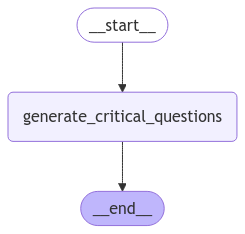

In [ ]:

from my_models.graph_tools import BasicCQModel
model_name = "o3-mini"

basic_agent = BasicCQModel(llm_name = model_name, temperature=None ) #interrupt_before=['human_feedback'], checkpointer=memory)


display(Image(basic_agent.graph.get_graph(xray=1).draw_mermaid_png()))

# RUN
# basic_agent.run_experiment()



### Evaulate 

- Run shell 

```shell

python3 eval_scripts/evaluation.py \
    --metric similarity \
    --input_path data_splits/validation.json \
    --submission_path output/output_o3-mini_temperatureNA.json \
    --threshold 0.6 

```

- OUTPUT : output/output_o3-mini_temperatureNA._eval_similarity_06.json



**Overall count**

| **Questions Labels** |  **#**  | **ratio** |
|:--------------------|-------:|---------:|
| useful               | **329** |  **0,59** |
| unhelpful            |      63 |      0,11 |
| Invalid              |       8 |      0,01 |
| Not able to evaluate |     158 |      0,28 |
| **Total**            | **558** |         1 |


**Overall count within each argument**

| **n/3 useful questions per arg** | **# of arguments** | **ratio** |
|:-------------------------------:|-------------------:|:---------:|
|                               0/3 |                 17 |      0,10 |
|                               1/3 |                 51 |      0,27 |
|                               2/3 |             **76** |      0,40 |
|                               3/3 |                 42 |      0,23 |
| **Total**                       |            **186** |         1 |